In [1]:
## Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import pybaseball
from pybaseball import *
from nameparser import HumanName
from lxml import html
from unidecode import unidecode

In [2]:
#loading dataset
path = 'C:/Users/kenne/mvp_analysis/mvp_voting_'
try:
    start_year = str(int(input('Enter start year:')))
    end_year = str(int(input('Enter end year:')))
except ValueError:
    print("Invalid input. Please enter a valid integer.")

file_path = path + start_year + "_" + end_year + ".csv"
df = pd.read_csv(file_path)
df.head()

Enter start year: 2007
Enter end year: 2023


,Year,Name,Tm,Vote Pts,1st Place,Share,WAR,G,AB,R,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
0,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,Alex Rodriguez,NYY,382.0,26.0,97%,9.4,158.0,583.0,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,Magglio Ordóñez,DET,258.0,2.0,66%,7.3,157.0,595.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007,Vladimir Guerrero,LAA,203.0,0.0,52%,4.6,150.0,574.0,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007,David Ortiz,BOS,177.0,0.0,45%,6.4,149.0,549.0,116.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#Labeling more features
df['Lg'] = None #League (NL or AL)
df.insert(0, 'Lg', df.pop('Lg')) 

df['Pos_Int'] = None #Position (Pitcher = 0, Batter = 1)
df.insert(0, 'Pos_Int', df.pop('Pos_Int'))

df['Pos'] = None #Position (String)
df.insert(0, 'Pos', df.pop('Pos')) 

df['LgYear'] = None #League + Year
df.insert(0, 'LgYear', df.pop('LgYear')) 

df['IsMvp_Int'] = None #Is MVP (Yes = 1, No = 0)
df.insert(0, 'IsMvp_Int', df.pop('IsMvp_Int')) 

df['IsMvp'] = None #Is MVP (String)
df.insert(0, 'IsMvp', df.pop('IsMvp')) 

df['Rank'] = None #Rank amongst competition
df.insert(0, 'Rank', df.pop('Rank')) 

df.head()

,Rank,IsMvp,IsMvp_Int,LgYear,Pos,Pos_Int,Lg,Year,Name,Tm,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
0,None,None,None,None,None,None,None,2007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,None,None,None,None,None,2007,Alex Rodriguez,NYY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,None,None,None,None,None,None,2007,Magglio Ordóñez,DET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,None,None,None,None,None,None,2007,Vladimir Guerrero,LAA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,None,None,None,None,None,None,2007,David Ortiz,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Classifying of said features
rnk = 0
lg = "NL"

for row in df.itertuples(index=True):
    year = row.Year
    name = row.Name
    index = row.Index
    era = row.ERA
    
    if pd.isna(name):
        rnk = 0
    df.at[index, 'Rank'] = rnk
    
    if (rnk == 1):
        df.at[index, 'IsMvp'] = "Yes"
        df.at[index, 'IsMvp_Int'] = 1
    else:
        df.at[index, 'IsMvp'] = "No"
        df.at[index, 'IsMvp_Int'] = 0

    if pd.isna(era):
        df.at[index, 'Pos'] = "Batter"
        df.at[index, 'Pos_Int'] = 1
    else:
        df.at[index, 'Pos'] = "Pitcher"
        df.at[index, 'Pos_Int'] = 0

    if pd.isna(name):
        if (lg == "NL"):
            lg = "AL"
        else:
            lg = "NL"
    df.at[index, 'Lg'] = lg
    df.at[index, 'LgYear'] = lg + str(year)[2:]

    rnk += 1

In [5]:
#Drop rows without a name
df.dropna(subset=['Name'], inplace=True)
df.head()

,Rank,IsMvp,IsMvp_Int,LgYear,Pos,Pos_Int,Lg,Year,Name,Tm,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
1,1,Yes,1,AL07,Batter,1,AL,2007,Alex Rodriguez,NYY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,No,0,AL07,Batter,1,AL,2007,Magglio Ordóñez,DET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,No,0,AL07,Batter,1,AL,2007,Vladimir Guerrero,LAA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,No,0,AL07,Batter,1,AL,2007,David Ortiz,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,No,0,AL07,Batter,1,AL,2007,Mike Lowell,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
al_mvp_winners = df[(df["IsMvp"] == "Yes") & (df["Lg"] == "AL")]
nl_mvp_winners = df[(df["IsMvp"] == "Yes") & (df["Lg"] == "NL")]

not_al_mvp_winners = df[(df["IsMvp"] == "No") & (df["Lg"] == "AL")]
not_nl_mvp_winners = df[(df["IsMvp"] == "No") & (df["Lg"] == "NL")]

not_al_mvp_winners_cnt = not_al_mvp_winners.groupby("Year").size()
not_nl_mvp_winners_cnt = not_nl_mvp_winners.groupby("Year").size()

#print(not_al_mvp_winners_cnt)
#print(not_nl_mvp_winners_cnt)

print("Avg number of AL non-winners in race from " + start_year + " to " + end_year + ": " + str(round(not_al_mvp_winners_cnt.mean(),2)))
print("Avg number of NL non-winners in race from " + start_year + " to " + end_year + ": " + str(round(not_nl_mvp_winners_cnt.mean(),2)))

Avg number of AL non-winners in race from 2007 to 2023: 22.76
Avg number of NL non-winners in race from 2007 to 2023: 23.82


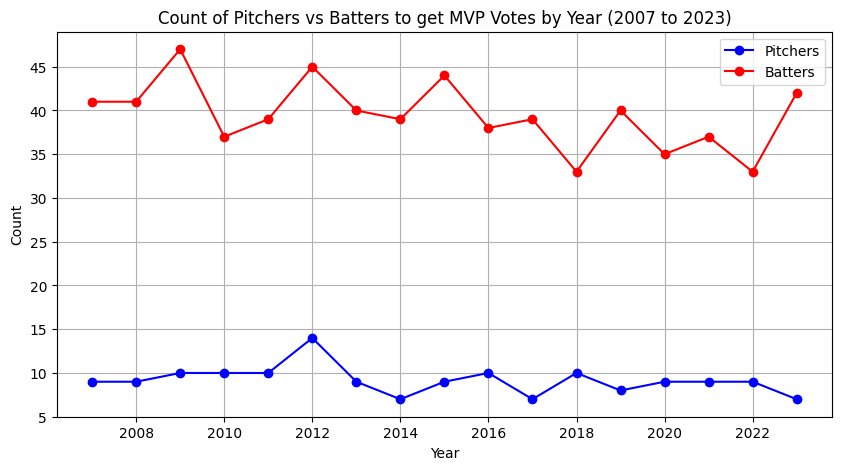

Correlation between pitcher count and batter count: 0.20648373847297175
Covariance between pitcher count and batter count: 1.2977941176470582 



In [7]:
# Filter the df for pitchers and batters
pitchers = df[df["Pos"] == "Pitcher"]
batters = df[df["Pos"] == "Batter"]

# Group by year and count the number of pitchers and batters
pitcher_cnt = pitchers.groupby("Year").size()
batter_cnt = batters.groupby("Year").size()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(pitcher_cnt.index, pitcher_cnt.values, marker='o', linestyle='-', color='blue', label='Pitchers')
plt.plot(batter_cnt.index, batter_cnt.values, marker='o', linestyle='-', color='red', label='Batters')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Pitchers vs Batters to get MVP Votes by Year (' + start_year + " to " + end_year +")")
plt.legend()
plt.grid(True)
plt.show()

correlation = pitcher_cnt.corr(batter_cnt)
print("Correlation between pitcher count and batter count:", correlation)
covariance = pitcher_cnt.cov(batter_cnt)
print("Covariance between pitcher count and batter count:", covariance, "\n")

Correlation between pitcher counts between leagues: -0.06284876358058004
Covariance between pitcher counts between leagues: -0.08823529411764713 

Correlation between batter counts between leagues: -0.3522104759200199
Covariance between batter counts between leagues: -3.9705882352941178 



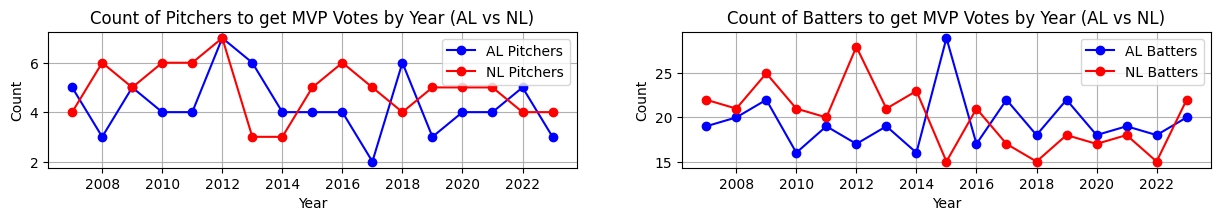

In [8]:

# Filter the DataFrame for AL and NL pitchers and batters
al_pitchers = df[(df["Pos"] == "Pitcher") & (df["Lg"] == "AL")]
nl_pitchers = df[(df["Pos"] == "Pitcher") &  (df["Lg"] == "NL")]

al_batters = df[(df["Pos"] == "Batter") &  (df["Lg"] == "AL")]
nl_batters = df[(df["Pos"] == "Batter") &  (df["Lg"] == "NL")]

# Group by year and count the number of pitchers and batters for AL and NL
al_pitcher_cnt = al_pitchers.groupby("Year").size()
nl_pitcher_cnt = nl_pitchers.groupby("Year").size()

al_batter_cnt = al_batters.groupby("Year").size()
nl_batter_cnt = nl_batters.groupby("Year").size()

# Plotting AL vs NL pitchers
plt.figure(figsize=(15, 6))

plt.subplot(3, 2, 1)
plt.plot(al_pitcher_cnt.index, al_pitcher_cnt.values, marker='o', linestyle='-', color='blue', label='AL Pitchers')
plt.plot(nl_pitcher_cnt.index, nl_pitcher_cnt.values, marker='o', linestyle='-', color='red', label='NL Pitchers')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Pitchers to get MVP Votes by Year (AL vs NL)')
plt.legend()
plt.grid(True)

# Plotting AL vs NL batters
plt.subplot(3, 2, 2)
plt.plot(al_batter_cnt.index, al_batter_cnt.values, marker='o', linestyle='-', color='blue', label='AL Batters')
plt.plot(nl_batter_cnt.index, nl_batter_cnt.values, marker='o', linestyle='-', color='red', label='NL Batters')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Batters to get MVP Votes by Year (AL vs NL)')
plt.legend()
plt.grid(True)

correlation = al_pitcher_cnt.corr(nl_pitcher_cnt)
print("Correlation between pitcher counts between leagues:", correlation)
covariance = al_pitcher_cnt.cov(nl_pitcher_cnt)
print("Covariance between pitcher counts between leagues:", covariance, "\n")

correlation = al_batter_cnt.corr(nl_batter_cnt)
print("Correlation between batter counts between leagues:", correlation)
covariance = al_batter_cnt.cov(nl_batter_cnt)
print("Covariance between batter counts between leagues:", covariance,"\n")

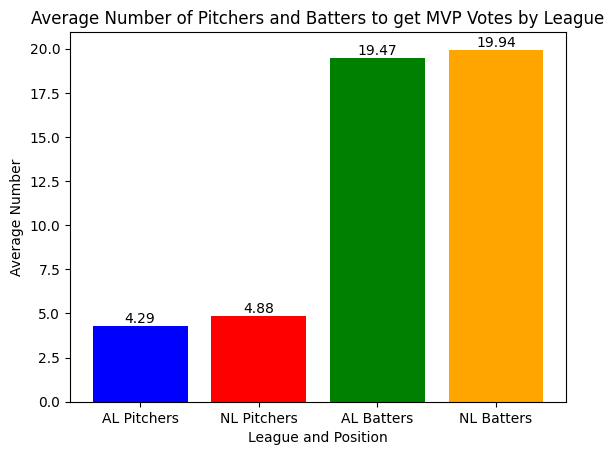

In [9]:
al_batter_avg = al_batter_cnt.mean()
nl_batter_avg = nl_batter_cnt.mean()
al_pitcher_avg = al_pitcher_cnt.mean()
nl_pitcher_avg = nl_pitcher_cnt.mean()

# Data for plotting
leagues = ['AL Pitchers', 'NL Pitchers', 'AL Batters', 'NL Batters']
averages = [al_pitcher_avg, nl_pitcher_avg, al_batter_avg, nl_batter_avg]

# Creating the bar plot
plt.bar(leagues, averages, color=['blue', 'red', 'green', 'orange'])
plt.xlabel('League and Position')
plt.ylabel('Average Number')
plt.title('Average Number of Pitchers and Batters to get MVP Votes by League')
# Adding numbers on the bars
for i, value in enumerate(averages):
    plt.text(i, value, round(value, 2), ha='center', va='bottom')
plt.show()

In [10]:
df['IsMvp_Int'] = df['IsMvp_Int'].astype(int)

# Identify groups where the rank 1 player is a pitcher
pitcher_groups = df.groupby('LgYear').apply(lambda x: x.iloc[0]['Pos'] == 'Pitcher')

# Extract indices of groups where the rank 1 player is a pitcher
indices_to_remove = pitcher_groups[pitcher_groups].index

# Drop these indices from the DataFrame
df_filtered = df[~df['LgYear'].isin(indices_to_remove)]

# Now df_filtered contains the DataFrame with groups remove

df_filtered = df_filtered[df_filtered['Pos'] != 'Pitcher'] #filter out all pitchers

C:\Users\kenne\AppData\Local\Temp\ipykernel_9320\3462315898.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pitcher_groups = df.groupby('LgYear').apply(lambda x: x.iloc[0]['Pos'] == 'Pitcher')


In [11]:
df_filtered.head()

,Rank,IsMvp,IsMvp_Int,LgYear,Pos,Pos_Int,Lg,Year,Name,Tm,...,ERA,WHIP,G.1,GS,SV,IP,H.1,HR.1,BB.1,SO
1,1,Yes,1,AL07,Batter,1,AL,2007,Alex Rodriguez,NYY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,No,0,AL07,Batter,1,AL,2007,Magglio Ordóñez,DET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,No,0,AL07,Batter,1,AL,2007,Vladimir Guerrero,LAA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,No,0,AL07,Batter,1,AL,2007,David Ortiz,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,No,0,AL07,Batter,1,AL,2007,Mike Lowell,BOS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df = df_filtered.drop(columns = ['ERA','WHIP','G.1','GS','SV','IP','H.1','HR.1','BB.1','SO', 'W', 
                                 'L', '1st Place','Lg','IsMvp','Pos','Pos_Int','Tm',
                                'Vote Pts', 'IsMvp_Int'])
df.head()

,Rank,LgYear,Year,Name,Share,WAR,G,AB,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS
1,1,AL07,2007,Alex Rodriguez,97%,9.4,158.0,583.0,143.0,183.0,54.0,156.0,24.0,95.0,0.314,0.422,0.645,1.067
2,2,AL07,2007,Magglio Ordóñez,66%,7.3,157.0,595.0,117.0,216.0,28.0,139.0,4.0,76.0,0.363,0.434,0.595,1.029
3,3,AL07,2007,Vladimir Guerrero,52%,4.6,150.0,574.0,89.0,186.0,27.0,125.0,2.0,71.0,0.324,0.403,0.547,0.950
4,4,AL07,2007,David Ortiz,45%,6.4,149.0,549.0,116.0,182.0,35.0,117.0,3.0,111.0,0.332,0.445,0.621,1.066
5,5,AL07,2007,Mike Lowell,32%,5.0,154.0,589.0,79.0,191.0,21.0,120.0,3.0,53.0,0.324,0.378,0.501,0.879


In [13]:
stats = batting_stats(start_year,end_year)
#stats.to_csv("stats.csv")

In [14]:
print("Df shape:",df.shape,"Stats shape:",stats.shape)

Df shape: (589, 18) Stats shape: (2438, 320)


In [15]:
# Rename the 'season' column to 'year' in the 'stats' DataFrame
stats.rename(columns={'Season': 'Year'}, inplace=True)

In [16]:
# Convert percentage strings into integers
df['Share'] = df['Share'].str.rstrip('%').astype(int)
df.head()

,Rank,LgYear,Year,Name,Share,WAR,G,AB,R,H,HR,RBI,SB,BB,BA,OBP,SLG,OPS
1,1,AL07,2007,Alex Rodriguez,97,9.4,158.0,583.0,143.0,183.0,54.0,156.0,24.0,95.0,0.314,0.422,0.645,1.067
2,2,AL07,2007,Magglio Ordóñez,66,7.3,157.0,595.0,117.0,216.0,28.0,139.0,4.0,76.0,0.363,0.434,0.595,1.029
3,3,AL07,2007,Vladimir Guerrero,52,4.6,150.0,574.0,89.0,186.0,27.0,125.0,2.0,71.0,0.324,0.403,0.547,0.950
4,4,AL07,2007,David Ortiz,45,6.4,149.0,549.0,116.0,182.0,35.0,117.0,3.0,111.0,0.332,0.445,0.621,1.066
5,5,AL07,2007,Mike Lowell,32,5.0,154.0,589.0,79.0,191.0,21.0,120.0,3.0,53.0,0.324,0.378,0.501,0.879


In [17]:
# Function to preprocess names
def preprocess_name(name):
    if pd.notna(name):  # Check if the value is not NaN
        # Remove accents
        name = unidecode(name)
        # Parse the name using nameparser
        parsed_name = HumanName(name)

        # Construct standardized name without suffix
        standardized_name = ' '.join([parsed_name.first, parsed_name.middle, parsed_name.last])
        
        # Replace periods with spaces
        standardized_name = standardized_name.replace('.', ' ')
        return standardized_name
    else:
        return None

# Standardize names in both data frames and drop suffixes
df['processed_name'] = df['Name'].apply(preprocess_name)
stats['processed_name'] = stats['Name'].apply(preprocess_name)

# Perform the join based on standardized names and year
merged_df = pd.merge(df, stats, how='inner', on=['processed_name', 'Year'])

# Drop the processed_name columns
merged_df = merged_df.drop(columns=['processed_name'])
df = merged_df

In [18]:
# Define a function for normalization
def normalize(group):
    # Filter columns with numeric data
    numeric_columns = group.select_dtypes(include=np.number).columns
    
    # Min-max normalization within each group for selected columns
    normalized_group = group.copy()
    normalized_group[numeric_columns] = (group[numeric_columns] - group[numeric_columns].min()) / (group[numeric_columns].max() - group[numeric_columns].min())
    return normalized_group

# Apply normalization within each group for all columns
df_normalized = df.groupby('LgYear').apply(normalize)

# Drop the 'LgYear' column from the resulting DataFrame
df_normalized.reset_index(drop=True, inplace=True)
df = df_normalized

df.head()

C:\Users\kenne\AppData\Local\Temp\ipykernel_9320\510748951.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = df.groupby('LgYear').apply(normalize)


,Rank,LgYear,Year,Name_x,Share,WAR_x,G_x,AB_x,R_x,H_x,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
0,1,AL07,NaN,Alex Rodriguez,1.000000,1.000000,0.914894,0.597458,1.0000,0.45,...,NaN,NaN,NaN,NaN,0.597403,0.711864,NaN,NaN,NaN,1.000000
1,2,AL07,NaN,Magglio Ordóñez,0.680412,0.708333,0.893617,0.648305,0.6750,0.78,...,NaN,NaN,NaN,NaN,0.454545,0.347458,NaN,NaN,NaN,0.794872
2,3,AL07,NaN,Vladimir Guerrero,0.536082,0.333333,0.744681,0.559322,0.3250,0.48,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,0.179487
3,4,AL07,NaN,David Ortiz,0.463918,0.583333,0.723404,0.453390,0.6625,0.44,...,NaN,NaN,NaN,NaN,0.467532,0.406780,NaN,NaN,NaN,0.576923
4,5,AL07,NaN,Mike Lowell,0.329897,0.388889,0.829787,0.622881,0.2000,0.53,...,NaN,NaN,NaN,NaN,0.915584,0.644068,NaN,NaN,NaN,0.346154


In [20]:
# Write the merged DataFrame to a CSV file
df.to_csv("mvp_voting_" + start_year +"_" + end_year + "_" + 'merged_data.csv', index=False)

print("Merged data saved to 'merged_data.csv'.")

print(df)

Merged data saved to 'merged_data.csv'.
    Rank LgYear  Year             Name_x     Share     WAR_x       G_x  \
0      1   AL07   NaN     Alex Rodriguez  1.000000  1.000000  0.914894   
1      2   AL07   NaN    Magglio Ordóñez  0.680412  0.708333  0.893617   
2      3   AL07   NaN  Vladimir Guerrero  0.536082  0.333333  0.744681   
3      4   AL07   NaN        David Ortiz  0.463918  0.583333  0.723404   
4      5   AL07   NaN        Mike Lowell  0.329897  0.388889  0.829787   
..   ...    ...   ...                ...       ...       ...       ...   
540   19   NL23   NaN      Marcell Ozuna  0.000000  0.350649  0.500000   
541   20   NL23   NaN     Kyle Schwarber  0.000000  0.000000  0.944444   
542   21   NL23   NaN     Dansby Swanson  0.000000  0.545455  0.583333   
543   23   NL23   NaN   Nick Castellanos  0.000000  0.116883  0.861111   
544   26   NL23   NaN   Christian Walker  0.000000  0.415584  0.861111   

         AB_x       R_x       H_x  ...     maxEV   HardHit  HardHit%  \